In [3]:
import os

def find_file(filename, search_path):
    for root, dirs, files in os.walk(search_path):
        if filename in files:
            return os.path.join(root, filename)
    return None

# Search from your home directory
real_path = find_file("aapl.us.txt", os.path.expanduser("~"))

if real_path:
    print("✅ Found:", real_path)
    df = pd.read_csv(real_path)
    print(df.head())
else:
    print("❌ Still couldn’t find aapl.us.txt")

✅ Found: /Users/aman/Stocks/aapl.us.txt
         Date     Open     High      Low    Close    Volume  OpenInt
0  1984-09-07  0.42388  0.42902  0.41874  0.42388  23220030        0
1  1984-09-10  0.42388  0.42516  0.41366  0.42134  18022532        0
2  1984-09-11  0.42516  0.43668  0.42516  0.42902  42498199        0
3  1984-09-12  0.42902  0.43157  0.41618  0.41618  37125801        0
4  1984-09-13  0.43927  0.44052  0.43927  0.43927  57822062        0


In [4]:
def preprocess_stock_data(df):
    df = df[["Open", "High", "Low", "Close", "Volume"]].copy()
    df = df.fillna(method="ffill").fillna(method="bfill")  # Handle missing
    df = (df - df.min()) / (df.max() - df.min())  # Normalize to 0–1
    return df

# Preprocess AAPL
processed_aapl = preprocess_stock_data(df)
print(processed_aapl.head())

       Open      High       Low     Close    Volume
0  0.001091  0.001103  0.001082  0.001103  0.011219
1  0.001091  0.001081  0.001052  0.001088  0.008708
2  0.001099  0.001146  0.001118  0.001132  0.020533
3  0.001121  0.001117  0.001067  0.001059  0.017937
4  0.001179  0.001168  0.001199  0.001190  0.027936


/var/folders/rd/6_34r_297z1c35xmsm7t1ywr0000gn/T/ipykernel_13888/547130878.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill").fillna(method="bfill")  # Handle missing


In [6]:
def preprocess_stock_data(df):
    df = df[["Open", "High", "Low", "Close", "Volume"]].copy()
    df = df.ffill().bfill()  # Clean missing values
    df = (df - df.min()) / (df.max() - df.min())  # Normalize 0–1
    return df

In [7]:
import torch
import torch.nn as nn

class DuelingDQN(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super(DuelingDQN, self).__init__()
        self.feature_layer = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU()
        )

        self.value_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        features = self.feature_layer(x)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        q_vals = values + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_vals

In [8]:
from collections import deque
import random
import numpy as np

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return (
            torch.FloatTensor(state),
            torch.LongTensor(action),
            torch.FloatTensor(reward),
            torch.FloatTensor(next_state),
            torch.BoolTensor(done)
        )

    def __len__(self):
        return len(self.buffer)

In [10]:
import gym
from gym import spaces
import numpy as np

class StocksEnv(gym.Env):
    def __init__(self, df):
        super(StocksEnv, self).__init__()
        self.df = df.values  # assume normalized dataframe
        self.max_steps = len(self.df) - 1
        self.current_step = 0

        self.initial_balance = 1000
        self.balance = self.initial_balance
        self.shares_held = 0
        self.total_profit = 0

        self.action_space = spaces.Discrete(3)  # 0 = Hold, 1 = Buy, 2 = Sell
        self.observation_space = spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)  # OHLCV

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.total_profit = 0
        return self._get_obs()

    def _get_obs(self):
        return self.df[self.current_step]

    def step(self, action):
        done = False
        reward = 0
        current_price = self.df[self.current_step][3]  # Close price

        if action == 1:  # Buy
            if self.balance >= current_price:
                self.shares_held += 1
                self.balance -= current_price
        elif action == 2:  # Sell
            if self.shares_held > 0:
                self.shares_held -= 1
                self.balance += current_price
                reward = current_price  # Profit reward

        self.current_step += 1
        if self.current_step >= self.max_steps:
            done = True
            # Final asset value as reward
            final_asset = self.balance + self.shares_held * current_price
            reward += final_asset - self.initial_balance

        next_obs = self._get_obs() if not done else np.zeros(self.observation_space.shape)
        return next_obs, reward, done, {}

In [11]:
env = StocksEnv(processed_aapl)

🎯 Episode 0 | Total Reward: 15.15
💾 Saved checkpoint: /Users/aman/Downloads/stock_market/dueling_dqn_checkpoint_ep0.pt
🎯 Episode 1 | Total Reward: 47.01
🎯 Episode 2 | Total Reward: 36.64
🎯 Episode 3 | Total Reward: 61.73
🎯 Episode 4 | Total Reward: 33.76
🎯 Episode 5 | Total Reward: 26.72
🎯 Episode 6 | Total Reward: 45.08
🎯 Episode 7 | Total Reward: 32.76
🎯 Episode 8 | Total Reward: 22.72
🎯 Episode 9 | Total Reward: 48.45
🎯 Episode 10 | Total Reward: 65.63
📈 Sharpe Ratio (last 10): 3.1243
💾 New BEST model saved: /Users/aman/Downloads/stock_market/best_dueling_dqn.pt (Sharpe: 3.1243)
🎯 Episode 11 | Total Reward: 104.34
🎯 Episode 12 | Total Reward: 41.16
🎯 Episode 13 | Total Reward: 12.84
🎯 Episode 14 | Total Reward: 4.61
🎯 Episode 15 | Total Reward: 6.68
🎯 Episode 16 | Total Reward: 5.09
🎯 Episode 17 | Total Reward: 11.98
🎯 Episode 18 | Total Reward: 70.50
🎯 Episode 19 | Total Reward: 8.72
🎯 Episode 20 | Total Reward: 13.04
📈 Sharpe Ratio (last 10): 0.8644
🎯 Episode 21 | Total Reward: 10

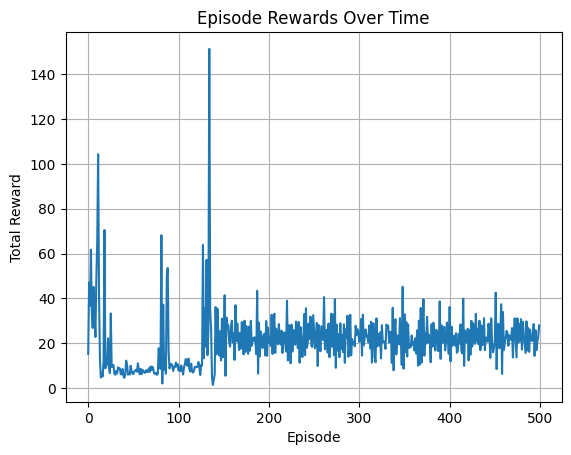

In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# === Create a writable folder ===
save_dir = os.path.expanduser("~/Downloads/stock_market")
os.makedirs(save_dir, exist_ok=True)

# === Dueling DQN Model ===
class DuelingDQN(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super(DuelingDQN, self).__init__()
        self.feature_layer = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU()
        )

        self.value_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        features = self.feature_layer(x)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        return values + (advantages - advantages.mean(dim=1, keepdim=True))

# === Replay Buffer ===
from collections import deque
import random

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return (
            torch.FloatTensor(state),
            torch.LongTensor(action),
            torch.FloatTensor(reward),
            torch.FloatTensor(next_state),
            torch.BoolTensor(done)
        )

    def __len__(self):
        return len(self.buffer)

# === Sharpe Ratio ===
def calculate_sharpe_ratio(rewards, risk_free_rate=0.0):
    returns = np.array(rewards)
    return (returns.mean() - risk_free_rate) / (returns.std() + 1e-8)

# === Your Custom Environment ===
# (Replace this with your own StocksEnv if it's different)
import gym
from gym import spaces

class StocksEnv(gym.Env):
    def __init__(self, df):
        super(StocksEnv, self).__init__()
        self.df = df.values
        self.max_steps = len(self.df) - 1
        self.current_step = 0

        self.initial_balance = 1000
        self.balance = self.initial_balance
        self.shares_held = 0

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        return self._get_obs()

    def _get_obs(self):
        return self.df[self.current_step]

    def step(self, action):
        done = False
        reward = 0
        current_price = self.df[self.current_step][3]  # Close price

        if action == 1:  # Buy
            if self.balance >= current_price:
                self.shares_held += 1
                self.balance -= current_price
        elif action == 2:  # Sell
            if self.shares_held > 0:
                self.shares_held -= 1
                self.balance += current_price
                reward = current_price

        self.current_step += 1
        if self.current_step >= self.max_steps:
            done = True
            final_asset = self.balance + self.shares_held * current_price
            reward += final_asset - self.initial_balance

        next_obs = self._get_obs() if not done else np.zeros(self.observation_space.shape)
        return next_obs, reward, done, {}

# === Use your preprocessed data ===
env = StocksEnv(processed_aapl)
obs_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

# === DQN Setup ===
policy_net = DuelingDQN(obs_dim, n_actions)
target_net = DuelingDQN(obs_dim, n_actions)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
buffer = ReplayBuffer()

# === Hyperparameters ===
n_episodes = 500
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 500
batch_size = 64
target_update = 10
episode_rewards = []
best_sharpe = -np.inf

def get_epsilon(step):
    return epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * step / epsilon_decay)

# === Training Loop ===
for episode in range(n_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    step = 0

    while not done:
        epsilon = get_epsilon(step)
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = policy_net(state_tensor)
                action = q_values.argmax().item()

        next_state, reward, done, _ = env.step(action)
        buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        step += 1

        if len(buffer) > batch_size:
            states, actions, rewards_, next_states, dones = buffer.sample(batch_size)

            q_vals = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()
            with torch.no_grad():
                next_q_vals = target_net(next_states).max(1)[0]
                target = rewards_ + gamma * next_q_vals * (~dones)

            loss = nn.MSELoss()(q_vals, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    episode_rewards.append(total_reward)
    print(f"🎯 Episode {episode} | Total Reward: {total_reward:.2f}")

    # 🔒 Checkpoint every 50 episodes
    if episode % 50 == 0:
        checkpoint_path = os.path.join(save_dir, f"dueling_dqn_checkpoint_ep{episode}.pt")
        torch.save(policy_net.state_dict(), checkpoint_path)
        print(f"💾 Saved checkpoint: {checkpoint_path}")

    # 📊 Sharpe Ratio Evaluation
    if episode >= 10 and episode % 10 == 0:
        recent_rewards = episode_rewards[-10:]
        sharpe = calculate_sharpe_ratio(recent_rewards)
        print(f"📈 Sharpe Ratio (last 10): {sharpe:.4f}")

        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_model_path = os.path.join(save_dir, "best_dueling_dqn.pt")
            torch.save(policy_net.state_dict(), best_model_path)
            print(f"💾 New BEST model saved: {best_model_path} (Sharpe: {sharpe:.4f})")

# === Plot Training Rewards ===
plt.plot(episode_rewards)
plt.title("Episode Rewards Over Time")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()


🧠 Training on window 0 to 200
Ep 0 | Reward: -1.22 | Sharpe: 0.000 | Portfolio: 1000.00
Ep 1 | Reward: -1.36 | Sharpe: -18.417 | Portfolio: 1000.00
Ep 2 | Reward: -1.29 | Sharpe: -22.556 | Portfolio: 1000.00
Ep 3 | Reward: 9.08 | Sharpe: 0.290 | Portfolio: 1000.00
Ep 4 | Reward: -1.03 | Sharpe: 0.203 | Portfolio: 1000.00
Ep 5 | Reward: -1.16 | Sharpe: 0.131 | Portfolio: 999.99
Ep 6 | Reward: -1.03 | Sharpe: 0.079 | Portfolio: 999.98
Ep 7 | Reward: -1.05 | Sharpe: 0.034 | Portfolio: 999.99
Ep 8 | Reward: -1.22 | Sharpe: -0.010 | Portfolio: 999.99
Ep 9 | Reward: -1.06 | Sharpe: -0.044 | Portfolio: 1000.00
Ep 10 | Reward: -1.02 | Sharpe: -0.037 | Portfolio: 1000.00
Ep 11 | Reward: -1.28 | Sharpe: -0.035 | Portfolio: 999.97
Ep 12 | Reward: -1.10 | Sharpe: -0.029 | Portfolio: 999.99
Ep 13 | Reward: -1.14 | Sharpe: -13.054 | Portfolio: 999.99
Ep 14 | Reward: -1.27 | Sharpe: -12.239 | Portfolio: 1000.00
Ep 15 | Reward: -1.23 | Sharpe: -11.769 | Portfolio: 999.99
Ep 16 | Reward: -1.19 | Sharp

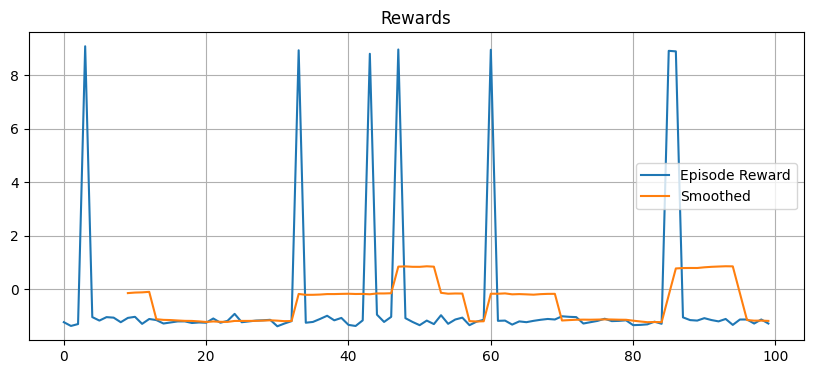

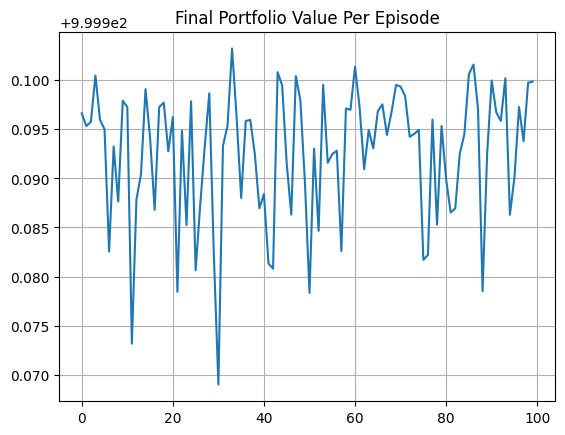

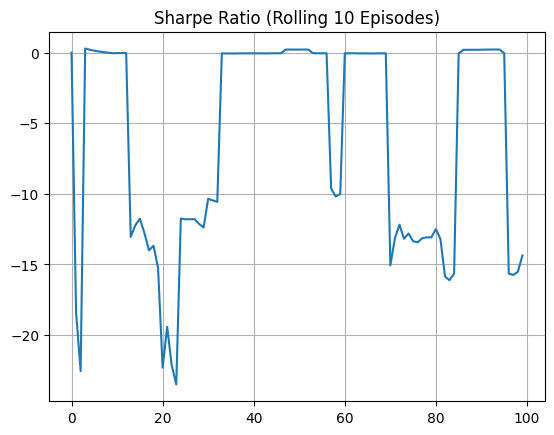


🧠 Training on window 20 to 220
Ep 0 | Reward: -1.04 | Sharpe: 0.000 | Portfolio: 1000.00
Ep 1 | Reward: -1.01 | Sharpe: -67.996 | Portfolio: 1000.00
Ep 2 | Reward: 8.95 | Sharpe: 0.489 | Portfolio: 1000.00
Ep 3 | Reward: -1.10 | Sharpe: 0.335 | Portfolio: 1000.00
Ep 4 | Reward: -1.08 | Sharpe: 0.236 | Portfolio: 999.99
Ep 5 | Reward: -1.09 | Sharpe: 0.162 | Portfolio: 999.99
Ep 6 | Reward: -1.17 | Sharpe: 0.100 | Portfolio: 999.99
Ep 7 | Reward: -1.16 | Sharpe: 0.049 | Portfolio: 999.99
Ep 8 | Reward: -1.20 | Sharpe: 0.003 | Portfolio: 1000.00
Ep 9 | Reward: 8.87 | Sharpe: 0.224 | Portfolio: 1000.00
Ep 10 | Reward: -1.34 | Sharpe: 0.215 | Portfolio: 1000.00
Ep 11 | Reward: -1.33 | Sharpe: 0.207 | Portfolio: 999.99
Ep 12 | Reward: -1.23 | Sharpe: -0.061 | Portfolio: 1000.00
Ep 13 | Reward: -1.37 | Sharpe: -0.070 | Portfolio: 1000.00
Ep 14 | Reward: -1.19 | Sharpe: -0.073 | Portfolio: 1000.00
Ep 15 | Reward: -1.36 | Sharpe: -0.082 | Portfolio: 999.97
Ep 16 | Reward: 8.83 | Sharpe: 0.186

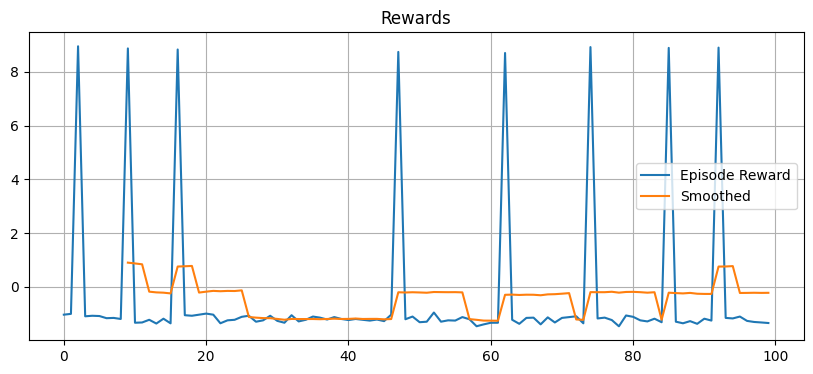

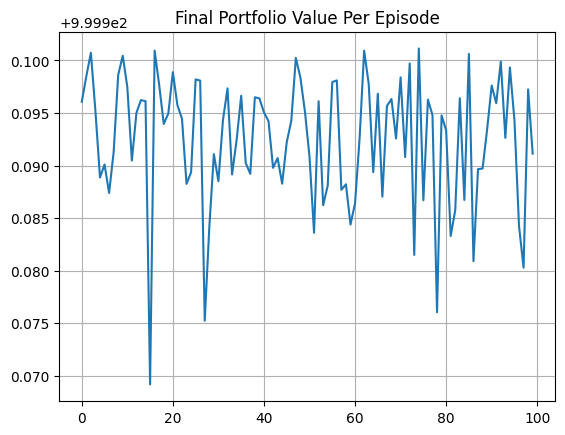

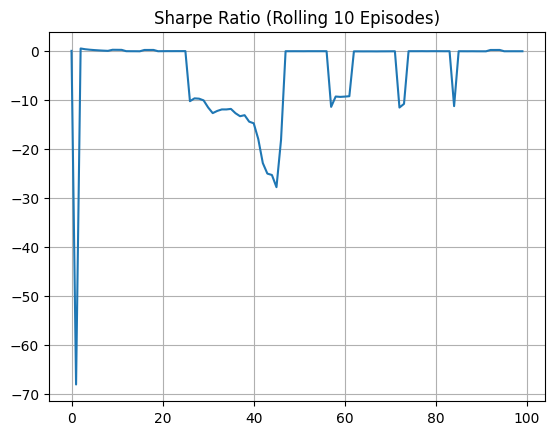


🧠 Training on window 40 to 240
Ep 0 | Reward: -1.20 | Sharpe: 0.000 | Portfolio: 999.99
Ep 1 | Reward: -1.02 | Sharpe: -12.284 | Portfolio: 1000.00
Ep 2 | Reward: -1.36 | Sharpe: -8.579 | Portfolio: 999.99
Ep 3 | Reward: -1.34 | Sharpe: -9.026 | Portfolio: 999.99
Ep 4 | Reward: 8.77 | Sharpe: 0.192 | Portfolio: 1000.00
Ep 5 | Reward: -1.34 | Sharpe: 0.112 | Portfolio: 999.99
Ep 6 | Reward: -1.32 | Sharpe: 0.048 | Portfolio: 999.99
Ep 7 | Reward: -1.08 | Sharpe: 0.004 | Portfolio: 1000.00
Ep 8 | Reward: 8.86 | Sharpe: 0.238 | Portfolio: 1000.00
Ep 9 | Reward: -1.25 | Sharpe: 0.192 | Portfolio: 1000.00
Ep 10 | Reward: -1.26 | Sharpe: 0.190 | Portfolio: 999.99
Ep 11 | Reward: -1.18 | Sharpe: 0.186 | Portfolio: 1000.00
Ep 12 | Reward: -1.22 | Sharpe: 0.190 | Portfolio: 1000.00
Ep 13 | Reward: -1.02 | Sharpe: 0.198 | Portfolio: 999.99
Ep 14 | Reward: -1.28 | Sharpe: -0.069 | Portfolio: 1000.00
Ep 15 | Reward: -1.15 | Sharpe: -0.063 | Portfolio: 1000.00
Ep 16 | Reward: -1.33 | Sharpe: -0.06

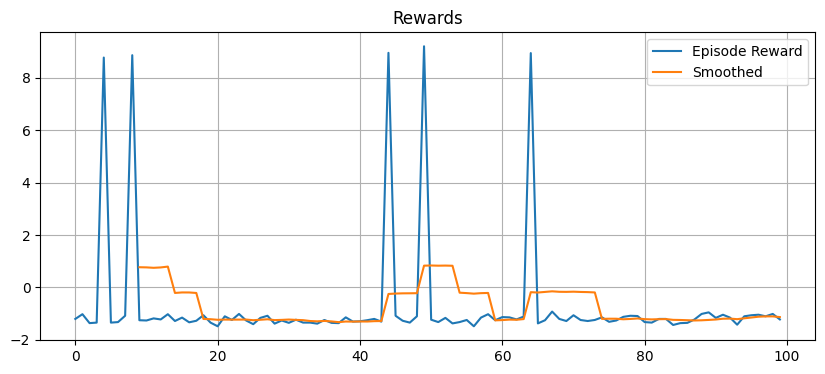

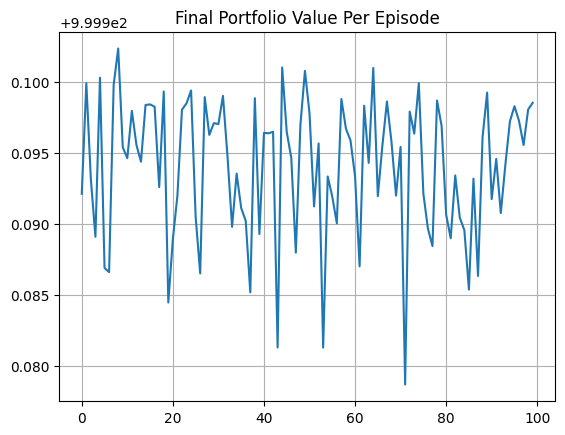

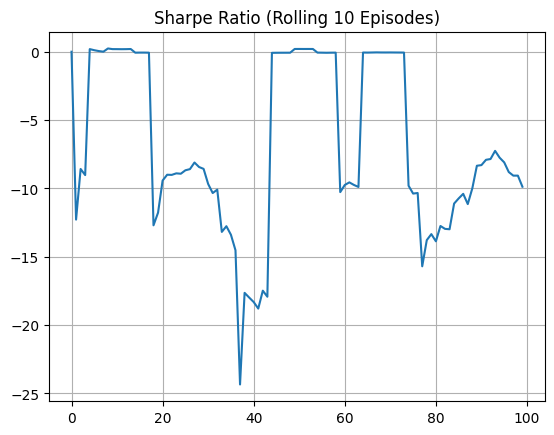


🧠 Training on window 60 to 260
Ep 0 | Reward: -1.33 | Sharpe: 0.000 | Portfolio: 999.99
Ep 1 | Reward: -1.12 | Sharpe: -11.636 | Portfolio: 1000.00
Ep 2 | Reward: -1.15 | Sharpe: -12.907 | Portfolio: 1000.00
Ep 3 | Reward: -1.30 | Sharpe: -13.409 | Portfolio: 1000.00
Ep 4 | Reward: -1.18 | Sharpe: -14.529 | Portfolio: 1000.00
Ep 5 | Reward: -1.16 | Sharpe: -15.242 | Portfolio: 999.99
Ep 6 | Reward: -1.23 | Sharpe: -16.407 | Portfolio: 999.99
Ep 7 | Reward: -1.26 | Sharpe: -17.149 | Portfolio: 1000.00
Ep 8 | Reward: -1.16 | Sharpe: -17.515 | Portfolio: 999.99
Ep 9 | Reward: -1.10 | Sharpe: -16.327 | Portfolio: 1000.00
Ep 10 | Reward: -1.24 | Sharpe: -19.413 | Portfolio: 999.99
Ep 11 | Reward: -1.16 | Sharpe: -20.653 | Portfolio: 1000.00
Ep 12 | Reward: -1.21 | Sharpe: -21.424 | Portfolio: 1000.00
Ep 13 | Reward: -1.23 | Sharpe: -25.520 | Portfolio: 999.99
Ep 14 | Reward: -1.48 | Sharpe: -12.502 | Portfolio: 999.98
Ep 15 | Reward: -1.04 | Sharpe: -10.881 | Portfolio: 1000.00
Ep 16 | Rew

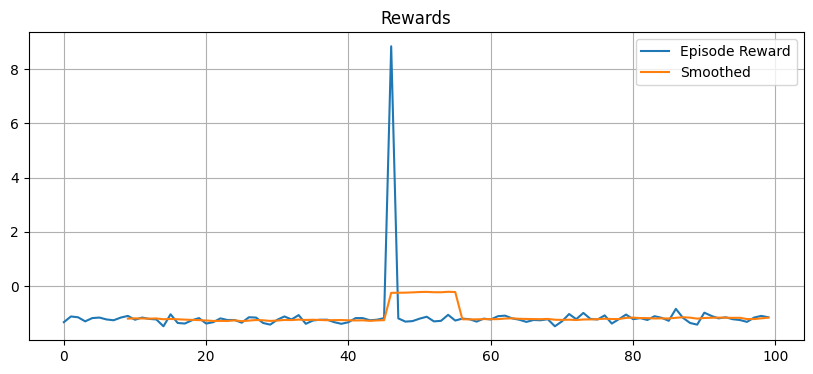

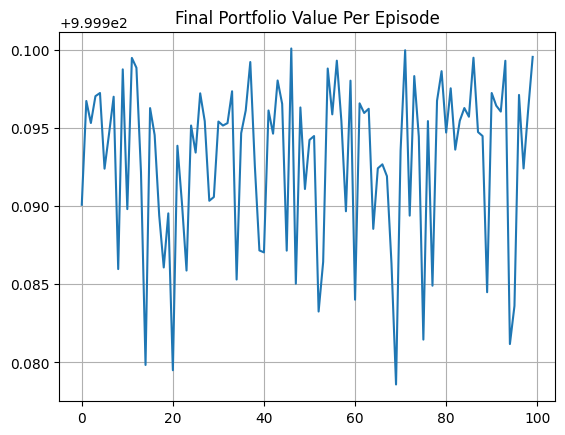

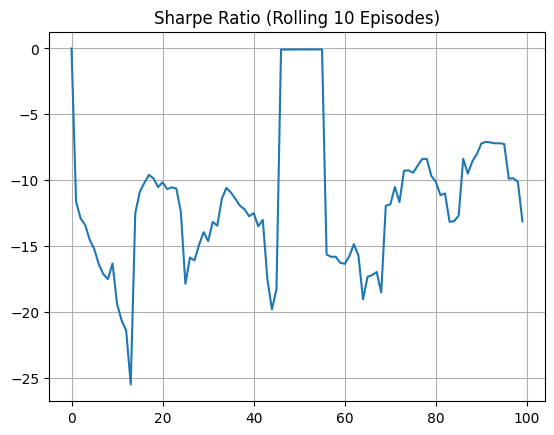


🧠 Training on window 80 to 280
Ep 0 | Reward: -1.14 | Sharpe: 0.000 | Portfolio: 1000.00
Ep 1 | Reward: -1.26 | Sharpe: -19.952 | Portfolio: 999.99
Ep 2 | Reward: -1.05 | Sharpe: -13.345 | Portfolio: 1000.00
Ep 3 | Reward: -1.16 | Sharpe: -15.418 | Portfolio: 1000.00
Ep 4 | Reward: -1.31 | Sharpe: -12.890 | Portfolio: 1000.00
Ep 5 | Reward: -1.15 | Sharpe: -13.893 | Portfolio: 1000.00
Ep 6 | Reward: -1.45 | Sharpe: -9.862 | Portfolio: 999.99
Ep 7 | Reward: -1.10 | Sharpe: -9.873 | Portfolio: 1000.00
Ep 8 | Reward: -1.37 | Sharpe: -9.671 | Portfolio: 1000.00
Ep 9 | Reward: -1.10 | Sharpe: -9.656 | Portfolio: 1000.00
Ep 10 | Reward: -1.24 | Sharpe: -9.888 | Portfolio: 1000.00
Ep 11 | Reward: -1.21 | Sharpe: -9.909 | Portfolio: 999.99
Ep 12 | Reward: -1.12 | Sharpe: -10.643 | Portfolio: 1000.00
Ep 13 | Reward: -1.17 | Sharpe: -10.701 | Portfolio: 999.99
Ep 14 | Reward: -1.34 | Sharpe: -10.485 | Portfolio: 1000.00
Ep 15 | Reward: -1.16 | Sharpe: -10.550 | Portfolio: 1000.00
Ep 16 | Reward

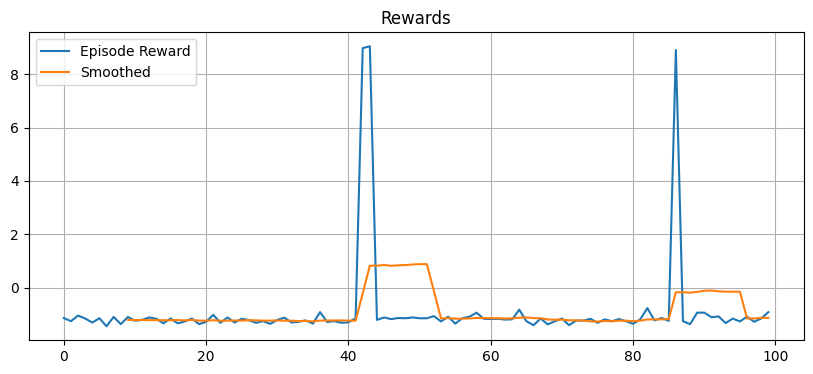

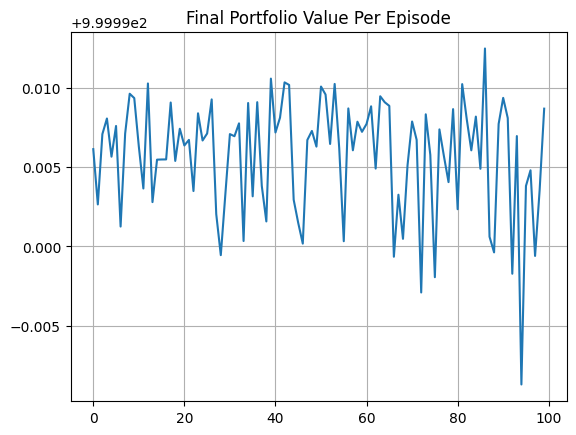

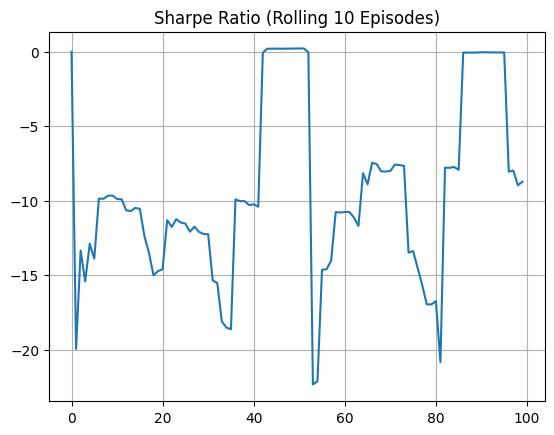


🧠 Training on window 100 to 300
Ep 0 | Reward: 8.88 | Sharpe: 0.000 | Portfolio: 1000.00
Ep 1 | Reward: -1.32 | Sharpe: 0.741 | Portfolio: 1000.00
Ep 2 | Reward: -1.25 | Sharpe: 0.439 | Portfolio: 999.99
Ep 3 | Reward: -1.42 | Sharpe: 0.276 | Portfolio: 999.99
Ep 4 | Reward: -1.13 | Sharpe: 0.185 | Portfolio: 1000.00
Ep 5 | Reward: -1.34 | Sharpe: 0.106 | Portfolio: 1000.00
Ep 6 | Reward: -1.38 | Sharpe: 0.042 | Portfolio: 1000.00
Ep 7 | Reward: -1.00 | Sharpe: 0.001 | Portfolio: 1000.00
Ep 8 | Reward: 8.73 | Sharpe: 0.233 | Portfolio: 1000.01
Ep 9 | Reward: -1.20 | Sharpe: 0.188 | Portfolio: 1000.00
Ep 10 | Reward: -1.02 | Sharpe: -0.078 | Portfolio: 999.99
Ep 11 | Reward: -1.30 | Sharpe: -0.077 | Portfolio: 999.99
Ep 12 | Reward: 8.72 | Sharpe: 0.192 | Portfolio: 1000.00
Ep 13 | Reward: -1.22 | Sharpe: 0.198 | Portfolio: 999.99
Ep 14 | Reward: 8.66 | Sharpe: 0.388 | Portfolio: 1000.00
Ep 15 | Reward: -1.26 | Sharpe: 0.391 | Portfolio: 1000.00
Ep 16 | Reward: -1.34 | Sharpe: 0.392 | 

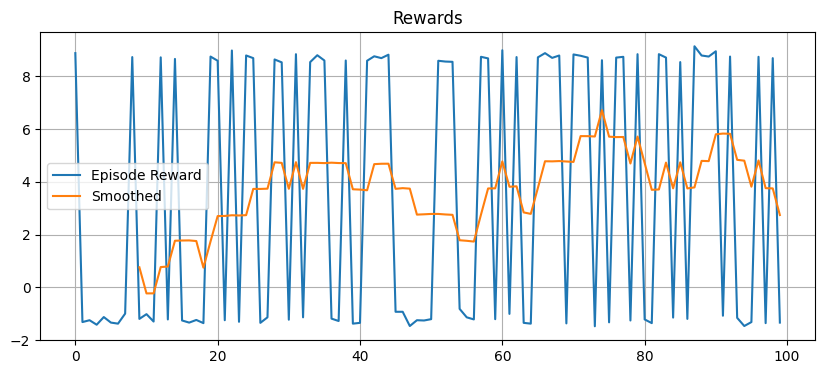

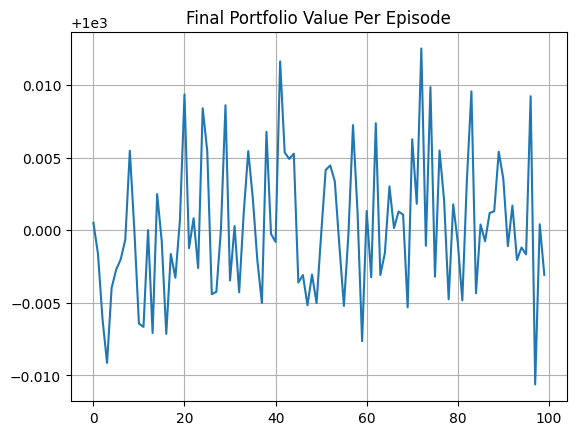

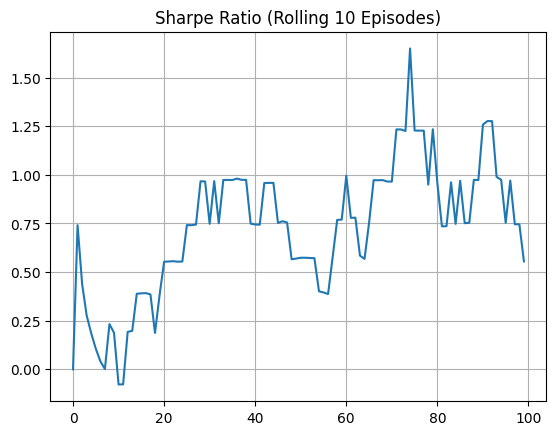


🧠 Training on window 120 to 320
Ep 0 | Reward: 8.73 | Sharpe: 0.000 | Portfolio: 1000.00
Ep 1 | Reward: 8.56 | Sharpe: 101.823 | Portfolio: 1000.00
Ep 2 | Reward: 8.94 | Sharpe: 56.315 | Portfolio: 1000.00
Ep 3 | Reward: -1.32 | Sharpe: 1.428 | Portfolio: 1000.00
Ep 4 | Reward: -1.31 | Sharpe: 0.958 | Portfolio: 1000.00
Ep 5 | Reward: 9.00 | Sharpe: 1.138 | Portfolio: 1000.00
Ep 6 | Reward: -1.26 | Sharpe: 0.895 | Portfolio: 1000.00
Ep 7 | Reward: 8.69 | Sharpe: 1.025 | Portfolio: 1000.00
Ep 8 | Reward: -1.21 | Sharpe: 0.863 | Portfolio: 1000.00
Ep 9 | Reward: -1.34 | Sharpe: 0.744 | Portfolio: 999.99
Ep 10 | Reward: 8.82 | Sharpe: 0.744 | Portfolio: 1000.01
Ep 11 | Reward: -1.34 | Sharpe: 0.556 | Portfolio: 1000.00
Ep 12 | Reward: 8.78 | Sharpe: 0.555 | Portfolio: 1000.00
Ep 13 | Reward: 8.84 | Sharpe: 0.744 | Portfolio: 1000.00
Ep 14 | Reward: 8.81 | Sharpe: 0.965 | Portfolio: 1000.01
Ep 15 | Reward: 8.66 | Sharpe: 0.963 | Portfolio: 1000.01
Ep 16 | Reward: 8.68 | Sharpe: 1.246 | Po

In [ ]:
import os
import gym
import torch
import ta
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gym import spaces
from collections import deque
import random

# === Setup Save Directory ===
save_dir = os.path.expanduser("~/Downloads/stock_market")
os.makedirs(save_dir, exist_ok=True)

# === Preprocess Function with Indicators ===
def preprocess_stock_data(df):
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)

    df["rsi"] = ta.momentum.RSIIndicator(close=df["Close"]).rsi()
    df["macd"] = ta.trend.MACD(close=df["Close"]).macd()
    bb = ta.volatility.BollingerBands(close=df["Close"])
    df["bollinger_h"] = bb.bollinger_hband()
    df["bollinger_l"] = bb.bollinger_lband()

    df = df[["Open", "High", "Low", "Close", "Volume", "rsi", "macd", "bollinger_h", "bollinger_l"]]
    df = df.ffill().bfill()
    df = (df - df.min()) / (df.max() - df.min())
    return df

# === Custom Stocks Environment ===
class StocksEnv(gym.Env):
    def __init__(self, df):
        super(StocksEnv, self).__init__()
        self.df = df.values
        self.max_steps = len(self.df) - 1
        self.current_step = 0

        self.initial_balance = 1000
        self.balance = self.initial_balance
        self.shares_held = 0
        self.trades = 0

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.df.shape[1],), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.trades = 0
        return self._get_obs()

    def _get_obs(self):
        return self.df[self.current_step]

    def step(self, action):
        done = False
        reward = 0
        current_price = self.df[self.current_step][3]  # Close price

        if action == 1:  # Buy
            if self.balance >= current_price:
                self.shares_held += 1
                self.balance -= current_price
                self.trades += 1
        elif action == 2:  # Sell
            if self.shares_held > 0:
                self.shares_held -= 1
                self.balance += current_price
                self.trades += 1

        self.current_step += 1
        if self.current_step >= self.max_steps:
            done = True
            portfolio_value = self.balance + self.shares_held * current_price
            profit_pct = (portfolio_value - self.initial_balance) / self.initial_balance
            reward = profit_pct * 100 - 0.01 * self.trades
            if profit_pct > 0:
                reward += 10

        next_obs = self._get_obs() if not done else np.zeros(self.observation_space.shape)
        return next_obs, reward, done, {}

# === Dueling DQN Model ===
class DuelingDQN(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super(DuelingDQN, self).__init__()
        self.feature = nn.Sequential(nn.Linear(obs_dim, 128), nn.ReLU())
        self.value = nn.Sequential(nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 1))
        self.advantage = nn.Sequential(nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, n_actions))

    def forward(self, x):
        x = self.feature(x)
        val = self.value(x)
        adv = self.advantage(x)
        return val + (adv - adv.mean(dim=1, keepdim=True))

# === Replay Buffer ===
class ReplayBuffer:
    def __init__(self, size=10000):
        self.buffer = deque(maxlen=size)

    def push(self, s, a, r, s2, d):
        self.buffer.append((s, a, r, s2, d))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s2, d = map(np.array, zip(*batch))
        return (
            torch.FloatTensor(s),
            torch.LongTensor(a),
            torch.FloatTensor(r),
            torch.FloatTensor(s2),
            torch.BoolTensor(d)
        )

    def __len__(self):
        return len(self.buffer)

# === Sharpe Ratio ===
def calculate_sharpe_ratio(rewards):
    returns = np.array(rewards)
    return (returns.mean() / (returns.std() + 1e-8)) if returns.size > 1 else 0

# === Training Function ===
def train_agent(env, n_episodes=200):
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    policy_net = DuelingDQN(obs_dim, n_actions)
    target_net = DuelingDQN(obs_dim, n_actions)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
    buffer = ReplayBuffer(100000)

    gamma = 0.99
    epsilon_start, epsilon_end, decay = 1.0, 0.01, 500
    batch_size = 64
    target_update = 10

    episode_rewards, sharpe_ratios, portfolio_vals = [], [], []

    for episode in range(n_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        actions = []
        portfolio = []

        step = 0
        while not done:
            epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * step / decay)
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_vals = policy_net(torch.FloatTensor(state).unsqueeze(0))
                    action = q_vals.argmax().item()

            actions.append(action)
            next_state, reward, done, _ = env.step(action)
            portfolio.append(env.balance + env.shares_held * env.df[env.current_step][3])
            buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            step += 1

            if len(buffer) >= batch_size:
                s, a, r, s2, d = buffer.sample(batch_size)
                q = policy_net(s).gather(1, a.unsqueeze(1)).squeeze()
                with torch.no_grad():
                    q_target = r + gamma * target_net(s2).max(1)[0] * (~d)
                loss = nn.MSELoss()(q, q_target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        episode_rewards.append(total_reward)
        sharpe_ratios.append(calculate_sharpe_ratio(episode_rewards[-10:]))
        portfolio_vals.append(portfolio[-1] if portfolio else env.initial_balance)

        print(f"Ep {episode} | Reward: {total_reward:.2f} | Sharpe: {sharpe_ratios[-1]:.3f} | Portfolio: {portfolio_vals[-1]:.2f}")

    # === Visualize ===
    plt.figure(figsize=(10, 4))
    plt.plot(episode_rewards, label='Episode Reward')
    plt.plot(pd.Series(episode_rewards).rolling(10).mean(), label='Smoothed')
    plt.title("Rewards")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.plot(portfolio_vals)
    plt.title("Final Portfolio Value Per Episode")
    plt.grid(True)
    plt.show()

    plt.plot(sharpe_ratios)
    plt.title("Sharpe Ratio (Rolling 10 Episodes)")
    plt.grid(True)
    plt.show()

# === Load your data and train ===
csv_path = "/Users/aman/Stocks/aapl.us.txt"  # CHANGE THIS IF NEEDED
raw_df = pd.read_csv(csv_path)
processed_df = preprocess_stock_data(raw_df)

# === Rolling Window Training ===
window_size = 200
stride = 20

for start in range(0, len(processed_df) - window_size, stride):
    window_df = processed_df.iloc[start:start + window_size]
    print(f"\n🧠 Training on window {start} to {start+window_size}")
    env = StocksEnv(window_df)
    train_agent(env, n_episodes=100)

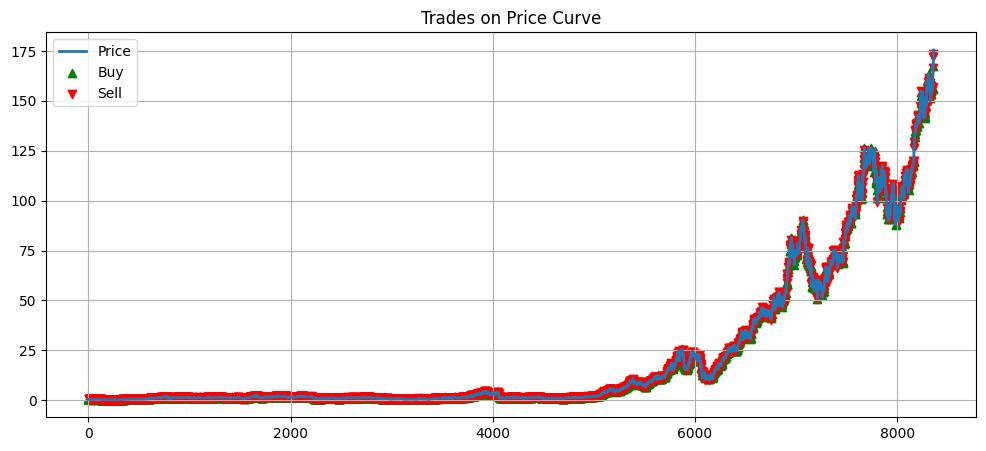

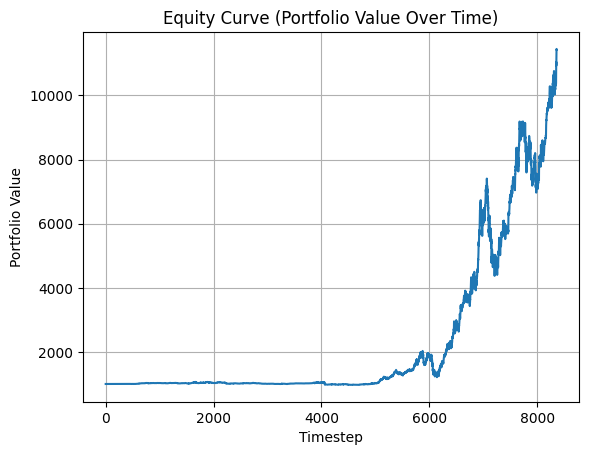

✅ Trade Win Rate: 64.08% (1770/2762 profitable sells)
📈 Final Portfolio Value: 11433.07
💼 Total Trades: 5525


In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta
from gym import spaces

# === Preprocess with Technical Indicators ===
def preprocess_stock_data(df):
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)

    # Technical indicators
    macd = ta.trend.MACD(close=df["Close"])
    df["macd"] = macd.macd()
    df["macd_signal"] = macd.macd_signal()
    df["price_slope"] = df["Close"].diff()
    df["sma_10"] = df["Close"].rolling(10).mean()
    df["dist_from_sma"] = df["Close"] - df["sma_10"]

    # Select + normalize
    df = df[["Open", "High", "Low", "Close", "Volume", "macd", "macd_signal", "price_slope", "dist_from_sma"]]
    df = df.ffill().bfill()
    df = (df - df.min()) / (df.max() - df.min())
    return df

# === Custom Environment ===
class StocksEnv(gym.Env):
    def __init__(self, df, original_df):
        super(StocksEnv, self).__init__()
        self.df = df.values
        self.price_df = original_df["Close"].reset_index(drop=True).values
        self.max_steps = len(self.df) - 1
        self.current_step = 0

        self.initial_balance = 1000
        self.balance = self.initial_balance
        self.shares_held = 0
        self.holding_time = 0
        self.trades = 0

        self.action_space = spaces.Discrete(3)  # 0 = hold, 1 = buy, 2 = sell
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.df.shape[1],), dtype=np.float32)

        self.portfolio_history = []
        self.action_history = []
        self.trade_log = []

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.holding_time = 0
        self.trades = 0
        self.portfolio_history = []
        self.action_history = []
        self.trade_log = []
        return self._get_obs()

    def _get_obs(self):
        return self.df[self.current_step]

    def step(self, action):
        done = False
        reward = 0
        price = self.price_df[self.current_step]
        prev_value = self.balance + self.shares_held * price

        self.action_history.append(action)

        if action == 1:  # Buy
            if self.balance >= price:
                self.shares_held += 1
                self.balance -= price
                self.trades += 1
                self.holding_time = 0
                self.trade_log.append(("BUY", self.current_step, price))
        elif action == 2:  # Sell
            if self.shares_held > 0:
                self.shares_held -= 1
                self.balance += price
                self.trades += 1
                reward += self.holding_time * 0.01  # reward for holding
                self.holding_time = 0
                self.trade_log.append(("SELL", self.current_step, price))
        else:
            reward -= 0.01  # idle penalty
            self.holding_time += 1

        self.current_step += 1
        done = self.current_step >= self.max_steps

        new_value = self.balance + self.shares_held * price
        reward += (new_value - prev_value) / self.initial_balance * 100
        self.portfolio_history.append(new_value)

        if done:
            profit_pct = (new_value - self.initial_balance) / self.initial_balance
            reward += profit_pct * 10  # final bonus

        obs = self._get_obs() if not done else np.zeros(self.observation_space.shape)
        return obs, reward, done, {}

# === Evaluation: Plot Trades + Portfolio ===
def plot_trades(env, original_df):
    prices = original_df["Close"].reset_index(drop=True)
    buy_pts = [i for i, a in enumerate(env.action_history) if a == 1]
    sell_pts = [i for i, a in enumerate(env.action_history) if a == 2]

    plt.figure(figsize=(12, 5))
    plt.plot(prices, label="Price", linewidth=2)
    plt.scatter(buy_pts, prices[buy_pts], marker="^", color="green", label="Buy")
    plt.scatter(sell_pts, prices[sell_pts], marker="v", color="red", label="Sell")
    plt.title("Trades on Price Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_equity_curve(env):
    plt.plot(env.portfolio_history)
    plt.title("Equity Curve (Portfolio Value Over Time)")
    plt.xlabel("Timestep")
    plt.ylabel("Portfolio Value")
    plt.grid(True)
    plt.show()

def calculate_trade_win_rate(env):
    buys = []
    wins = 0
    for action, step, price in env.trade_log:
        if action == "BUY":
            buys.append((step, price))
        elif action == "SELL" and buys:
            _, buy_price = buys.pop(0)
            if price > buy_price:
                wins += 1
    total = len(env.trade_log) // 2
    win_rate = wins / total if total else 0
    print(f"✅ Trade Win Rate: {win_rate:.2%} ({wins}/{total} profitable sells)")

# === Example Usage ===
csv_path = "/Users/aman/Stocks/aapl.us.txt"  # change if needed
raw_df = pd.read_csv(csv_path)
processed_df = preprocess_stock_data(raw_df)

env = StocksEnv(processed_df, raw_df)

# Simulate a few steps with random actions
obs = env.reset()
done = False
while not done:
    action = np.random.choice([0, 1, 2])
    obs, reward, done, _ = env.step(action)

# === Visualization & Evaluation ===
plot_trades(env, raw_df)
plot_equity_curve(env)
calculate_trade_win_rate(env)
print(f"📈 Final Portfolio Value: {env.portfolio_history[-1]:.2f}")
print(f"💼 Total Trades: {env.trades}")

[*********************100%***********************]  1 of 1 completed


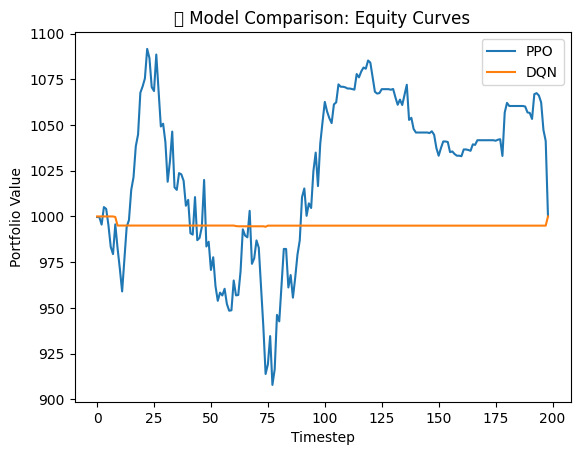

In [7]:
import gym
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, DQN, SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from gym import spaces
import warnings
warnings.filterwarnings("ignore")

# === CONFIGS ===
STOCK = "AAPL"
START_DATE = "2015-01-01"
END_DATE = "2022-12-31"
INITIAL_BALANCE = 1000
TRANSACTION_COST = 0.001  # 0.1%
SLIPPAGE = 0.001          # 0.1%
WINDOW_SIZE = 200
ROLLOUT_STEP = 100

# === DOWNLOAD DATA ===
def download_data(stock, start, end):
    df = yf.download(stock, start=start, end=end)
    df = df[['Close']].rename(columns={'Close': 'price'})
    df['returns'] = df['price'].pct_change().fillna(0)
    return df

# === CUSTOM TRADING ENV ===
class TradingEnv(gym.Env):
    def __init__(self, df):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.action_space = spaces.Discrete(3)  # 0: hold, 1: buy, 2: sell
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(5,), dtype=np.float32)
        self.reset()

    def reset(self):
        self.step_index = 0
        self.balance = INITIAL_BALANCE
        self.shares_held = 0
        self.portfolio_value = INITIAL_BALANCE
        self.last_trade_price = 0
        self.trades = []
        return self._get_obs()

    def _get_obs(self):
        price = float(self.df.loc[self.step_index, 'price'])
        returns = float(self.df.loc[self.step_index, 'returns'])
        return np.array([
           price,
           returns,
           float(self.shares_held),
           float(self.portfolio_value),
           float(self.balance)
        ], dtype=np.float32)

    def step(self, action):
        done = self.step_index >= len(self.df) - 2
        price = float(self.df.loc[self.step_index, 'price'])
        fee = float(TRANSACTION_COST * price + SLIPPAGE * price)

        if action == 1:  # Buy
           if self.balance > price + fee:
                self.shares_held += 1
                self.balance -= (price + fee)
                self.trades.append(('buy', self.step_index, price))
        elif action == 2:  # Sell
           if self.shares_held > 0:
                self.shares_held -= 1
                self.balance += (price - fee)
                self.trades.append(('sell', self.step_index, price))

        self.portfolio_value = self.balance + self.shares_held * price
        reward = (self.portfolio_value - INITIAL_BALANCE) / INITIAL_BALANCE

        self.step_index += 1
        return self._get_obs(), reward, done, {}

# === TRAINING LOOP ===
def train_and_evaluate(env_class, df, model_class, name):
    models = []
    values = []
    windows = []

    for start in range(0, len(df) - WINDOW_SIZE, ROLLOUT_STEP):
        window_df = df.iloc[start:start+WINDOW_SIZE].copy()
        env = DummyVecEnv([lambda: env_class(window_df)])
        model = model_class("MlpPolicy", env, verbose=0)
        model.learn(total_timesteps=10000)
        obs = env.reset()
        done = False
        rewards, val_curve = [], []
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            rewards.append(reward)
            val_curve.append(env.get_attr("portfolio_value")[0])
        models.append(model)
        values.append(val_curve)
        windows.append(start)
    return models, values, windows

# === PLOTTING ===
def plot_results(portfolio_vals, labels):
    for val_curve, label in zip(portfolio_vals, labels):
        plt.plot(val_curve[-1], label=label)
    plt.title("📈 Model Comparison: Equity Curves")
    plt.xlabel("Timestep")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.show()

# === MAIN PIPELINE ===
df = download_data(STOCK, START_DATE, END_DATE)

ppo_models, ppo_vals, _ = train_and_evaluate(TradingEnv, df, PPO, "PPO")
dqn_models, dqn_vals, _ = train_and_evaluate(TradingEnv, df, DQN, "DQN")

plot_results([ppo_vals, dqn_vals], ["PPO", "DQN"])

✅ Found: /Users/aman/Stocks/aapl.us.txt
         Date     Open     High      Low    Close    Volume  OpenInt
0  1984-09-07  0.42388  0.42902  0.41874  0.42388  23220030        0
1  1984-09-10  0.42388  0.42516  0.41366  0.42134  18022532        0
2  1984-09-11  0.42516  0.43668  0.42516  0.42902  42498199        0
3  1984-09-12  0.42902  0.43157  0.41618  0.41618  37125801        0
4  1984-09-13  0.43927  0.44052  0.43927  0.43927  57822062        0
